# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [27]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [28]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [29]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [30]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [31]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [32]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [33]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [34]:
client = MongoClient(mongod_connect)
db = client.gp17 # use or create a database named demo
tweet_collection = db.lab10 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [35]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [36]:
track = ['covid19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [37]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

1326219502825082881
1326219502594392065
1326219503135563776
1326219503600988161
1326219503747870720
1326219505606012928
1326219507870953472
1326219507677995009
1326219508466380800
1326219509120856064
1326219509406031872
1326219510030888961
1326219510102306817
1326219511868035072
1326219511960395780
1326219512694202368
1326219513386446849
1326219513906475008
1326219514334212096
1326219514556669954
1326219515089342468
1326219515588382723
1326219515575853058
1326219518096576512
1326219518323142657
1326219519539470336
1326219519510147073
1326219519556276230
1326219519854055431
1326219520114122758
1326219520218968065
1326219520776744961
1326219521078689792
1326219521175265284
1326219521745702912
1326219521842089984
1326219521573654529
1326219522760613888
1326219523415040002
1326219524941750274
1326219525193338881
1326219525545713664
1326219525524742144
1326219525575020545
1326219527139569665
1326219527210762240
1326219527655354368
1326219527840026630
1326219527907139595
1326219527785472000


KeyboardInterrupt: 

## Use the REST API to Collect Tweets

Authorize the REST API 

In [38]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [39]:
count = 100 #number of returned tweets, default and max is 100
#geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [40]:
search_results = rest_api.search.tweets( count=count,q=q) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

TwitterHTTPError: Twitter sent status 429 for URL: 1.1/search/tweets.json using parameters: (count=100&oauth_consumer_key=LrW7wvuuqZHFI4m9js6yAXbLj&oauth_nonce=2888866043364408565&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1605030396&oauth_token=60388598-jXU1MD84HUZFNSLAAQd92UUhF3LBh8CXvPzGqBzro&oauth_version=1.0&q=covid19&oauth_signature=w9CdOX%2FZR9E7%2FoOxToWeemeYjJg%3D)
details: {'errors': [{'message': 'Rate limit exceeded', 'code': 88}]}

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [41]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                         max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

TwitterHTTPError: Twitter sent status 429 for URL: 1.1/search/tweets.json using parameters: (count=100&max_id=1326204940218462211&oauth_consumer_key=LrW7wvuuqZHFI4m9js6yAXbLj&oauth_nonce=14301037701534395453&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1605030406&oauth_token=60388598-jXU1MD84HUZFNSLAAQd92UUhF3LBh8CXvPzGqBzro&oauth_version=1.0&q=covid19&oauth_signature=lJC3GRv10hIIQnH69Gt4K3f%2BBaQ%3D)
details: {'errors': [{'message': 'Rate limit exceeded', 'code': 88}]}

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [42]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

18181
15688


Create a text index and print the Tweets containing specific keywords. 

In [43]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [44]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pprint to display tweets

In [45]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: All Express News
text: Election 2020: A look at Trump campaign election lawsuits and where they stand SEE MORE HERE ==&gt;… https://t.co/dIaIwrfxTC
----
name: SturmTruMppen™ 🆘
text: Detroit, Wayne County election crimes lawsuit launched to overturn &amp; redo election. 
But in TCF while counting ball… https://t.co/k5baMzC1Tm
----
name: IADOSKentucky🇺🇸(IAM🚫POC)
text: RT @tonetalks: Cable media keeps talking about the election like it’s Election night. No you don’t get to keep celebrating. We all agree Tr…
----
name: aZiZi
text: RT @tonetalks: Cable media keeps talking about the election like it’s Election night. No you don’t get to keep celebrating. We all agree Tr…
----
name: Jennifer Morrell
text: RT @joegoldman: Election workers have made heroic sacrifices for this country
----
name: Run. Stumble. Walk.
text: @spark_show @davidakin We'll know in about two weeks what the COVID19 implications are from the US election.  Yikes!
----
name: Cindi Lou Who - Hug Dispensor 🇺🇸👠🌈🌊🆘🍑


In [46]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pandas to display tweets

In [47]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,quoted_status_id_str,quoted_status,retweeted_status,quoted_status_permalink,quote_count,reply_count,filter_level,timestamp_ms,display_text_range,extended_tweet
0,5faad06fbdbb593a85e1a924,Tue Nov 10 17:12:19 +0000 2020,1326211093946130433,1326211093946130433,Election 2020: A look at Trump campaign electi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.akidthaine.com"" rel=""nofol...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5faad0c1bdbb593a85e1c5fb,Tue Nov 10 16:52:41 +0000 2020,1326206154209337346,1326206154209337346,"Detroit, Wayne County election crimes lawsuit ...",True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1326173802015969284,{'created_at': 'Tue Nov 10 14:44:08 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5faad087bdbb593a85e1b12c,Tue Nov 10 17:06:47 +0000 2020,1326209701881802755,1326209701881802755,RT @tonetalks: Cable media keeps talking about...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,{'created_at': 'Tue Nov 10 02:24:08 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5faad074bdbb593a85e1aaa1,Tue Nov 10 17:11:19 +0000 2020,1326210844724658176,1326210844724658176,RT @tonetalks: Cable media keeps talking about...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,{'created_at': 'Tue Nov 10 02:24:08 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5faad1e4bdbb593a85e1ce3d,Tue Nov 10 17:46:06 +0000 2020,1326219598878842880,1326219598878842880,RT @joegoldman: Election workers have made her...,False,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1326151770645655553,{'created_at': 'Tue Nov 10 13:16:35 +0000 2020...,{'created_at': 'Tue Nov 10 17:45:32 +0000 2020...,"{'url': 'https://t.co/3BuS79IU8a', 'expanded':...",0.0,0.0,low,1605030366998,NaN,NaN
5,5faad0babdbb593a85e1c3ad,Tue Nov 10 16:54:18 +0000 2020,1326206560792694786,1326206560792694786,@spark_show @davidakin We'll know in about two...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.326206e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5faad099bdbb593a85e1b7e9,Tue Nov 10 17:02:04 +0000 2020,1326208517397598210,1326208517397598210,RT @axidentaliberal: WE CANNOT LET #MoscowMitc...,False,"{'hashtags': [{'text': 'MoscowMitchMcConnell',...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1325963551840768001,NaN,{'created_at': 'Tue Nov 10 02:04:28 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5faad084bdbb593a85e1b04a,Tue Nov 10 17:07:24 +0000 2020,1326209857486249985,1326209857486249985,RT @axidentaliberal: WE CANNOT LET #MoscowMitc...,False,"{'hashtags': [{'text': 'MoscowMitchMcConnell',...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1325963551840768001,NaN,{'created_at': 'Tue Nov 10 02:04:28 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5faad038bdbb593a85e19514,Tue Nov 10 17:26:57 +0000 2020,1326214776926728200,1326214776926728200,"Look at that, a president-elect working. \n\n#...",True,"{'hashtags': [{'text': 'BidenTransition', 'ind...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1326214285949865986,{'created_at': 'Tue Nov 10 17:25:00 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5faad0d3bdbb593a85e1cc67,Tue Nov 

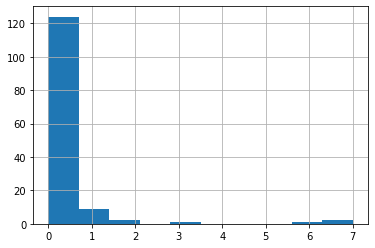

In [48]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count